In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасетов красного и белого вина
url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

df_red = pd.read_csv(url_red, sep=';')
df_white = pd.read_csv(url_white, sep=';')

# Добавим признак "type" — 0 для красного, 1 для белого
df_red['type'] = 0
df_white['type'] = 1

# Объединим датасеты
df = pd.concat([df_red, df_white], ignore_index=True)

# Просмотр первых строк
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [9]:
print(df.info())
print(df.describe())
print(df['quality'].value_counts())
print(df['type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \

In [10]:
# Выберем числовые признаки (кроме целевой 'quality' и 'type')
num_features = df.columns.drop(['quality', 'type'])

# 1) StandardScaler
scaler_std = StandardScaler()
df_std = df.copy()
df_std[num_features] = scaler_std.fit_transform(df[num_features])

# 2) MinMaxScaler
scaler_mm = MinMaxScaler()
df_mm = df.copy()
df_mm[num_features] = scaler_mm.fit_transform(df[num_features])

# 3) RobustScaler
scaler_rob = RobustScaler()
df_rob = df.copy()
df_rob[num_features] = scaler_rob.fit_transform(df[num_features])

# Проверка результата (пример для StandardScaler)
print(df_std[num_features].head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       3.073817         -0.362438     1.661085       -0.744778   0.541412   
4       0.142473          2.188833    -2.192833       -0.744778   0.569958   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.100140             -1.446359  1.034993  1.813090   0.193097   
1            -0.311320             -0.862469  0.701486 -0.115073   0.999579   
2            -0.874763             -1.092486  0.768188  0.258120   0.797958   
3            -0.762074             -0.986324  1.101694 -0.363868   0.327510   
4            -1.100140             -1.446359  1.034993  1.813090   0.193097   

    alcohol  
0 -0.915464  
1 -0.580068  
2 -0.580068  


In [11]:
# Удаление выбросов по IQR для признака 'residual sugar'
Q1 = df['residual sugar'].quantile(0.25)
Q3 = df['residual sugar'].quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[(df['residual sugar'] >= Q1 - 1.5 * IQR) & (df['residual sugar'] <= Q3 + 1.5 * IQR)]
print(f"Размер до удаления выбросов: {df.shape[0]}, после: {df_no_outliers.shape[0]}")

# Замена выбросов на медиану для 'residual sugar'
median_sugar = df['residual sugar'].median()
df_replace_outliers = df.copy()
outliers = (df_replace_outliers['residual sugar'] < (Q1 - 1.5 * IQR)) | (df_replace_outliers['residual sugar'] > (Q3 + 1.5 * IQR))
df_replace_outliers.loc[outliers, 'residual sugar'] = median_sugar


Размер до удаления выбросов: 6497, после: 6379


In [12]:
start_date = pd.to_datetime('2020-01-01')
df['date'] = [start_date + pd.Timedelta(days=i) for i in range(len(df))]

df[['date']].head()

,date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05


In [13]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

# Удалим исходный признак 'date'
df = df.drop(columns=['date'])

df[['year', 'month', 'day', 'dayofweek', 'is_weekend']].head()

,year,month,day,dayofweek,is_weekend
0,2020,1,1,2,0
1,2020,1,2,3,0
2,2020,1,3,4,0
3,2020,1,4,5,1
4,2020,1,5,6,1


In [14]:
# Целевая переменная — бинаризуем качество вина: quality >=7 - хорошее (1), иначе (0)
df_encoded['target'] = (df_encoded['quality'] >= 7).astype(int)

# Признаки (исключаем 'quality' и целевой 'target')
X = df_encoded.drop(columns=['quality', 'target'])
y = df_encoded['target']

# 6.1 Метод фильтрации (SelectKBest с f_classif)
selector_filter = SelectKBest(score_func=f_classif, k=5)
X_new_filter = selector_filter.fit_transform(X, y)
selected_features_filter = X.columns[selector_filter.get_support()]
print("Отобранные признаки фильтрацией:", list(selected_features_filter))

# 6.2 Метод обёртки (RFE с логистической регрессией)
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)
selected_features_wrapper = X.columns[rfe.support_]
print("Отобранные признаки обёрткой:", list(selected_features_wrapper))

# 6.3 Встроенный метод (Lasso)
lasso = Lasso(alpha=0.005, max_iter=10000)
lasso.fit(X, y)
selected_features_embedded = X.columns[lasso.coef_ != 0]
print("Отобранные признаки встроенным методом:", list(selected_features_embedded))


Отобранные признаки фильтрацией: ['volatile acidity', 'chlorides', 'density', 'alcohol', 'type_1']


C:\Users\artem\OneDrive\Рабочий стол\Бомонка\Мага\2 семестр\MMO\venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Отобранные признаки обёрткой: ['volatile acidity', 'chlorides', 'pH', 'sulphates', 'alcohol']
Отобранные признаки встроенным методом: ['fixed acidity', 'volatile acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol']


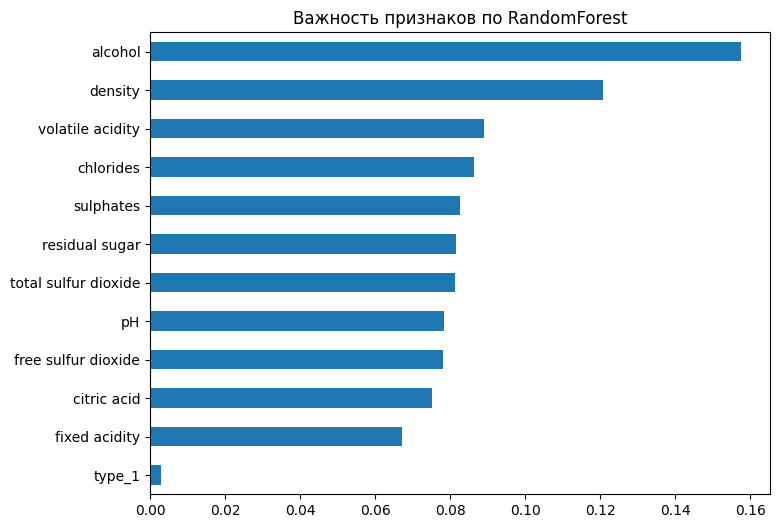

In [15]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Важность признаков по RandomForest")
plt.show()
